In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join
import itertools
import admix_genet_cor
import submitit
import glob
from scipy.stats import pearsonr, linregress
from tqdm import tqdm
import string
from natsort import natsorted
import pickle

import matplotlib

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

In [2]:
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            [0.025, 0.05, 0.1, 0.2],
            [62, 125, 250, 500, 1000],
            np.arange(500),
        )
    ],
    columns=["hsq", "ncausal", "sim_i"],
)
df_params["prefix"] = df_params.apply(
    lambda row: f"hsq-{row.hsq}-ncausal-{int(row.ncausal)}",
    axis=1,
)

In [3]:
result_file = "results/dict_df_res.pkl"
if os.path.exists(result_file):
    with open(result_file, "rb") as f:
        dict_df_res = pickle.load(f)
else:
    dict_df_res = {}

    for group in ["causal", "clump"]:
        df_res = []
        for i, param in tqdm(df_params.iterrows(), total=len(df_params)):
            path = f"out/summary/{param.prefix}.sim_{param.sim_i}.{group}.tsv"
            if os.path.exists(path):
                df_tmp = pd.read_csv(path, sep="\t")
                # perform filtering on the causal df (not done)
                # df_tmp = df_tmp[df_tmp.assoc_p < 5e-8]
                df_tmp["ncausal"] = param.ncausal
                df_tmp["hsq"] = param.hsq
                df_tmp["sim_i"] = param.sim_i
                df_tmp["pos"] = df_tmp.snp.apply(lambda x: int(x.split(":")[1]))
                df_res.append(df_tmp)
        df_res = pd.concat(df_res).reset_index(drop=True)
        # filter for SNPs with super small MAF in either one of the populations
        df_res = df_res[(df_res.se1 > 1e-6) & (df_res.se2 > 1e-6)]
        print(group, np.mean(df_res.het_pval < 0.05))
        dict_df_res[group] = df_res

    with open(result_file, "wb") as f:
        pickle.dump(dict_df_res, f)

In [4]:
dict_df_res["causal"] = dict_df_res["causal"][dict_df_res["causal"].assoc_p < 5e-8]

In [5]:
dict_df_res["causal"].groupby(["hsq", "ncausal"]).size()

hsq    ncausal
0.025  62          1826
       125          922
       250          291
       500           71
       1000          16
0.050  62          4764
       125         3747
       250         2037
       500          703
       1000         206
0.100  62          8868
       125         9734
       250         7905
       500         4753
       1000        2092
0.200  62         13396
       125        17968
       250        19978
       500        17504
       1000       11806
dtype: int64

In [6]:
for group in dict_df_res:
    dict_df_res[group] = dict_df_res[group][dict_df_res[group].hsq >= 0.1]

In [7]:
def summarize_res(df_res_grouped):
    # 1st local ancestry = EUR, 2nd local ancestry = AFR
    df_plot = pd.DataFrame(
        {
            "het_inflation": df_res_grouped.apply(
                lambda x: admix.data.lambda_gc(x["het_pval"])
            ),  # HET p-value
            "het_fpr": df_res_grouped.apply(lambda x: np.mean(x["het_pval"] < 0.05)),
            "pearsonr": df_res_grouped.apply(
                lambda x: pearsonr(x["coef1"], x["coef2"])[0]
            ),  # Pearson's correlation between two coefficents
            "deming_eur~afr": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef2"], y=x["coef1"], sx=x["se2"], sy=x["se1"]
                )[0]
            ),  # EUR ~ AFR
            "deming_afr~eur": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef1"], y=x["coef2"], sx=x["se1"], sy=x["se2"]
                )[0]
            ),  # AFR ~ EUR
            "ols_eur~afr": df_res_grouped.apply(
                lambda x: linregress(x=x["coef2"], y=x["coef1"])[0]
            ),
            "ols_afr~eur": df_res_grouped.apply(
                lambda x: linregress(x=x["coef1"], y=x["coef2"])[0]
            ),
        }
    )

    df_plot = df_plot.reset_index(drop=False)
    return df_plot

# Main figure

In [9]:
n_bootstrap = 100
sample_size = 1000

np.random.seed(1234)

dict_df_plot = {}

for group in ["causal", "clump"]:
    df_plot = []
    for i in tqdm(range(n_bootstrap)):
        df_plot.append(
            summarize_res(
                dict_df_res[group]
                .groupby(["ncausal", "hsq"])
                .sample(n=sample_size, replace=False)
                .groupby(["ncausal", "hsq"])
            ).set_index(["ncausal", "hsq"])
        )
    df_plot_mean = pd.DataFrame(
        np.mean(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
    ).reset_index()
    df_plot_se = pd.DataFrame(
        np.std(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
    ).reset_index()
    dict_df_plot[group] = (df_plot_mean, df_plot_se)

100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


In [8]:
dict_column_name = {
    "het_fpr": "HET FPR",
    "deming_afr~eur": "Deming (AFR$\sim$EUR)",
    "deming_eur~afr": "Deming (EUR$\sim$AFR)",
    "pearsonr": "Pearson r",
    "ols_afr~eur": "OLS (AFR$\sim$EUR)",
    "ols_eur~afr": "OLS (EUR$\sim$AFR)",
}

In [19]:
stratify_by = ["ncausal", "hsq"]
for group in ["causal", "clump"]:
    df_plot, df_plot_se = dict_df_plot[group]
    df_display = (
        df_plot.set_index(stratify_by).round(3).astype(str)
        + " ("
        + df_plot_se.set_index(stratify_by).round(3).astype(str)
        + ")"
    )
    print(f"## {group}")

    print(
        f"At ncausal=500, hsq=0.1, het_fpr={df_display.loc[(500, 0.1), 'het_fpr']}, deming_afr~eur={df_display.loc[(500, 0.1), 'deming_afr~eur']}"
    )
    df_display = df_display[dict_column_name.keys()].rename(columns=dict_column_name)
    df_display.index = df_display.index.set_levels(
        [f"{int(f * 100)}\%" for f in df_display.index.levels[1]], level=1
    )
    display(df_display)
    # save these latex to locus-simulation-multiple-causal[1,2].tex
    print(df_display.to_latex(escape=False))
    print("\n\n")
    df_display.to_csv(f"results/multiple-causal.{group}.tsv", sep="\t")

## causal
At ncausal=500, hsq=0.1, het_fpr=0.249 (0.012), deming_afr~eur=0.922 (0.013)


HET FPR Deming (AFR$\sim$EUR) Deming (EUR$\sim$AFR)  \
ncausal hsq                                                               
62      10\%  0.181 (0.011)         0.985 (0.011)         1.015 (0.011)   
        20\%   0.25 (0.013)         0.995 (0.012)         1.005 (0.012)   
125     10\%  0.195 (0.013)         0.987 (0.012)         1.014 (0.012)   
        20\%  0.279 (0.015)         0.979 (0.014)         1.022 (0.015)   
250     10\%  0.203 (0.011)         0.975 (0.013)         1.025 (0.013)   
        20\%  0.304 (0.014)         0.958 (0.017)         1.044 (0.019)   
500     10\%  0.249 (0.012)         0.922 (0.013)         1.085 (0.016)   
        20\%  0.307 (0.015)         0.954 (0.019)         1.049 (0.021)   
1000    10\%   0.28 (0.011)         0.942 (0.012)         1.062 (0.014)   
        20\%  0.361 (0.015)         0.906 (0.022)         1.105 (0.026)   

                  Pearson r OLS (AFR$\sim$EUR) OLS (EUR$\sim$AFR)  
ncausal hsq                                                        
62      10\%  0.916 (0.008)      0.858 (0.015)      0.978 (0.013)  
        20\%  0.926 (0.005)      0.885 (0.013)      0.969 (0.012)  
125     10\%   0.884 (0.01)      0.817 (0.018)      0.957 (0.014)  
        20\%  0.892 (0.007)       0.83 (0.015)      0.959 (0.015)  
250     10\%  0.874 (0.009)      0.804 (0.016)       0.95 (0.013)  
        20\%  0.852 (0.009)      0.773 (0.016)        0.94 (0.02)  
500     10\%  0.838 (0.011)      0.739 (0.016)      0.951 (0.015)  
        20\%  0.817 (0.011)      0.729 (0.018)      0.917 (0.019)  
1000    10\%  0.818 (0.009)      0.732 (0.014)      0.914 (0.014)  
        20\%  0.761 (0.014)      0.651 (0.017)       0.89 (0.026)

\begin{tabular}{llllllll}
\toprule
     &      &        HET FPR & Deming (AFR$\sim$EUR) & Deming (EUR$\sim$AFR) &      Pearson r & OLS (AFR$\sim$EUR) & OLS (EUR$\sim$AFR) \\
ncausal & hsq &                &                       &                       &                &                    &                    \\
\midrule
62   & 10\% &  0.181 (0.011) &         0.985 (0.011) &         1.015 (0.011) &  0.916 (0.008) &      0.858 (0.015) &      0.978 (0.013) \\
     & 20\% &   0.25 (0.013) &         0.995 (0.012) &         1.005 (0.012) &  0.926 (0.005) &      0.885 (0.013) &      0.969 (0.012) \\
125  & 10\% &  0.195 (0.013) &         0.987 (0.012) &         1.014 (0.012) &   0.884 (0.01) &      0.817 (0.018) &      0.957 (0.014) \\
     & 20\% &  0.279 (0.015) &         0.979 (0.014) &         1.022 (0.015) &  0.892 (0.007) &       0.83 (0.015) &      0.959 (0.015) \\
250  & 10\% &  0.203 (0.011) &         0.975 (0.013) &         1.025 (0.013) &  0.874 (0.009) &      0.804 (0.016) &    

HET FPR Deming (AFR$\sim$EUR) Deming (EUR$\sim$AFR)  \
ncausal hsq                                                               
62      10\%  0.234 (0.013)         0.963 (0.013)         1.038 (0.014)   
        20\%  0.354 (0.015)          0.923 (0.02)         1.084 (0.024)   
125     10\%   0.23 (0.012)         0.971 (0.015)         1.031 (0.016)   
        20\%  0.357 (0.013)         0.908 (0.021)         1.102 (0.026)   
250     10\%  0.217 (0.013)          0.97 (0.013)         1.031 (0.014)   
        20\%  0.355 (0.015)         0.921 (0.019)         1.087 (0.022)   
500     10\%   0.25 (0.013)         0.941 (0.018)          1.063 (0.02)   
        20\%  0.351 (0.014)          0.915 (0.02)         1.094 (0.024)   
1000    10\%   0.28 (0.012)         0.923 (0.016)         1.083 (0.018)   
        20\%  0.395 (0.017)         0.875 (0.024)         1.144 (0.031)   

                  Pearson r OLS (AFR$\sim$EUR) OLS (EUR$\sim$AFR)  
ncausal hsq                                                        
62      10\%  0.548 (0.057)      0.383 (0.062)      0.789 (0.066)  
        20\%  0.426 (0.046)      0.275 (0.044)      0.662 (0.075)  
125     10\%  0.606 (0.082)      0.498 (0.095)      0.745 (0.101)  
        20\%  0.462 (0.047)      0.345 (0.054)      0.626 (0.083)  
250     10\%  0.669 (0.075)      0.567 (0.097)      0.798 (0.099)  
        20\%  0.514 (0.055)       0.395 (0.07)      0.679 (0.086)  
500     10\%  0.632 (0.057)      0.531 (0.087)       0.759 (0.08)  
        20\%  0.502 (0.061)      0.414 (0.083)      0.619 (0.089)  
1000    10\%  0.535 (0.067)      0.466 (0.088)      0.621 (0.071)  
        20\%  0.459 (0.064)      0.393 (0.081)      0.543 (0.076)

\begin{tabular}{llllllll}
\toprule
     &      &        HET FPR & Deming (AFR$\sim$EUR) & Deming (EUR$\sim$AFR) &      Pearson r & OLS (AFR$\sim$EUR) & OLS (EUR$\sim$AFR) \\
ncausal & hsq &                &                       &                       &                &                    &                    \\
\midrule
62   & 10\% &  0.234 (0.013) &         0.963 (0.013) &         1.038 (0.014) &  0.548 (0.057) &      0.383 (0.062) &      0.789 (0.066) \\
     & 20\% &  0.354 (0.015) &          0.923 (0.02) &         1.084 (0.024) &  0.426 (0.046) &      0.275 (0.044) &      0.662 (0.075) \\
125  & 10\% &   0.23 (0.012) &         0.971 (0.015) &         1.031 (0.016) &  0.606 (0.082) &      0.498 (0.095) &      0.745 (0.101) \\
     & 20\% &  0.357 (0.013) &         0.908 (0.021) &         1.102 (0.026) &  0.462 (0.047) &      0.345 (0.054) &      0.626 (0.083) \\
250  & 10\% &  0.217 (0.013) &          0.97 (0.013) &         1.031 (0.014) &  0.669 (0.075) &      0.567 (0.097) &    

In [16]:
# select one h2g = 0.05 / 0.1
# x-axis: Number of causal variants per Mb
# y-axis metrics
# hue: causal clump

In [10]:
hsq = 0.1

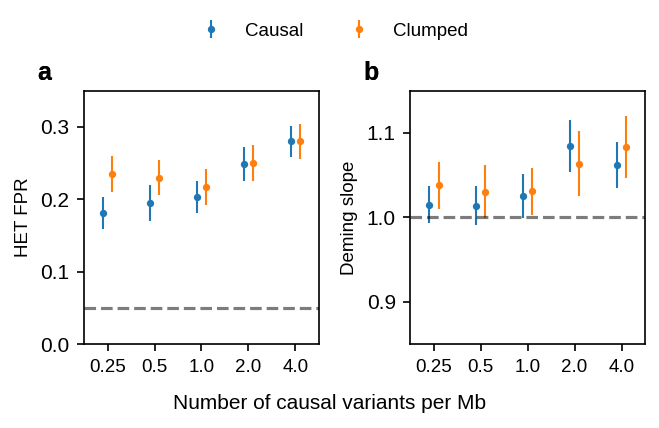

In [11]:
yvar_list = [
    "het_fpr",
    "deming_eur~afr",
]
dict_ylabel = {
    "het_fpr": "HET FPR",
    "deming_eur~afr": "Deming slope",
}
dict_ylim = {
    "het_fpr": [0, 0.35],
    "deming_eur~afr": [0.85, 1.15],
}
dict_yticks = {
    "het_fpr": [0, 0.1, 0.2, 0.3],
    "deming_eur~afr": [0.9, 1.0, 1.1],
}
dict_hline = {
    "het_fpr": 0.05,
    "deming_eur~afr": 1.0,
}


fig, axes = plt.subplots(figsize=(4.5, 2.4), ncols=2, dpi=150)

# for causal SNPs and clumped SNPs
for group_i, group in enumerate(["causal", "clump"]):
    df_mean, df_se = dict_df_plot[group]
    # filter for single causal variant
    df_mean = df_mean[df_mean.hsq == hsq]
    df_se = df_se[df_se.hsq == hsq]

    # for each panel
    for i, yvar in enumerate(yvar_list):
        ax = axes[i]

        if i == 0:
            label = {
                "causal": "Causal",
                "clump": "Clumped",
            }[group]
        else:
            label = None

        ax.errorbar(
            np.arange(len(df_mean.ncausal)) - 0.1 + 0.2 * group_i,
            df_mean[yvar],
            yerr=df_se[yvar] * 1.96,
            fmt=".",
            ms=5,
            linewidth=1,
            mew=1,
            label=label,
        )

        ax.axhline(y=dict_hline[yvar], color="black", ls="--", alpha=0.3)
        ax.set_xticks(np.arange(len(df_mean.ncausal)))
        ax.set_xticklabels([0.25, 0.5, 1.0, 2.0, 4.0], fontsize=9)
        ax.set_yticks(dict_yticks[yvar])
        ax.set_ylabel(dict_ylabel[yvar], fontsize=9)
        ax.set_ylim(dict_ylim[yvar])

        # annotation
        ax.text(
            -0.2,
            1.04,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )
        ax.set_xlim(-0.5, 4.5)


# trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)
fig.text(
    0.5,
    -0.03,
    "Number of causal variants per Mb",
    fontsize=10,
    ha="center",
)
plt.tight_layout()
plt.savefig("results/chrom-simulation.pdf", bbox_inches="tight")

# Supp. figure varying sample size

In [13]:
n_bootstrap = 100
np.random.seed(1234)

dict_vary_n = dict()
for sample_size in [50, 100, 500]:

    dict_df_plot = {}

    for group in ["causal", "clump"]:
        df_plot = []
        for i in tqdm(range(n_bootstrap)):
            df_plot.append(
                summarize_res(
                    dict_df_res[group]
                    .groupby(["ncausal", "hsq"])
                    .sample(n=sample_size, replace=False)
                    .groupby(["ncausal", "hsq"])
                ).set_index(["ncausal", "hsq"])
            )
        df_plot_mean = pd.DataFrame(
            np.mean(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
        ).reset_index()
        df_plot_se = pd.DataFrame(
            np.std(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
        ).reset_index()
        dict_df_plot[group] = (df_plot_mean, df_plot_se)
    dict_vary_n[sample_size] = dict_df_plot

100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


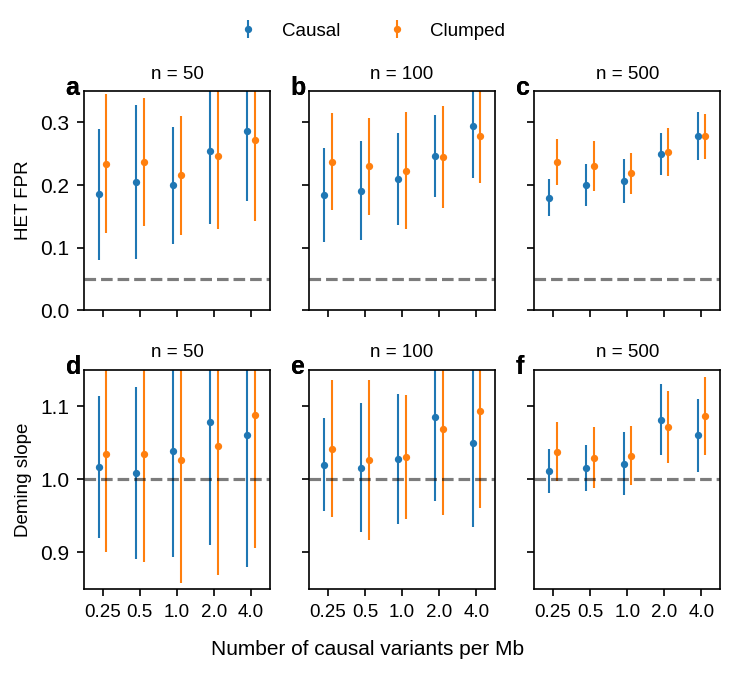

In [14]:
fig, axes = plt.subplots(
    figsize=(5, 4), nrows=2, ncols=3, dpi=150, sharey="row", sharex=True
)
for i_sample, sample_size in enumerate([50, 100, 500]):
    dict_df_plot = dict_vary_n[sample_size]
    # for causal SNPs and clumped SNPs
    for group_i, group in enumerate(["causal", "clump"]):
        df_mean, df_se = dict_df_plot[group]
        # filter for single causal variant
        df_mean = df_mean[df_mean.hsq == hsq]
        df_se = df_se[df_se.hsq == hsq]

        # for each panel
        for i, yvar in enumerate(yvar_list):
            ax = axes[i, i_sample]

            if i == 0:
                label = {
                    "causal": "Causal",
                    "clump": "Clumped",
                }[group]
            else:
                label = None

            ax.errorbar(
                np.arange(len(df_mean.ncausal)) - 0.1 + 0.2 * group_i,
                df_mean[yvar],
                yerr=df_se[yvar] * 1.96,
                fmt=".",
                ms=5,
                linewidth=1,
                mew=1,
                label=label,
            )

            ax.axhline(y=dict_hline[yvar], color="black", ls="--", alpha=0.3)
            ax.set_xticks(np.arange(len(df_mean.ncausal)))
            ax.set_xticklabels([0.25, 0.5, 1.0, 2.0, 4.0], fontsize=9)
            ax.set_yticks(dict_yticks[yvar])
            ax.set_ylim(dict_ylim[yvar])
            if i_sample == 0:
                ax.set_ylabel(dict_ylabel[yvar], fontsize=9)
            ax.set_title(f"n = {sample_size}", fontsize=9)
            # annotation
            ax.text(
                -0.1,
                0.98,
                string.ascii_lowercase[i * 3 + i_sample],
                transform=ax.transAxes,
                size=12,
                weight="bold",
            )
            ax.set_xlim(-0.5, 4.5)


# trick to put title in the same row
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)
fig.text(
    0.5,
    -0.02,
    "Number of causal variants per Mb",
    fontsize=10,
    ha="center",
)
plt.tight_layout()
plt.savefig("results/chrom-simulation-vary-n.pdf", bbox_inches="tight")